**Jupyter Notebook illustrating first iteration of ISIMIP implementation integrated with default set of evaluation metrics**

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
from PACKAGE_NAME.evaluate import evaluation_functions
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


**Set variables to investigate**

In [3]:
variables = ['tas']

# Data import and pre-processing

In [4]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_future = cm[:, :, 9001:]

    dates = {
        "obs": get_dates(obs),
        "obs_validate": get_dates(obs_validate),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_future, dates


In [5]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_future, tas_dates = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_future, pr_dates = preprocess_isimip_evaluation_testing_data('pr')

# Evaluation phase 1 - test assumptions

## Goodness of fit

In [7]:
tas_obs_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_obs)
print('AIC fit observed data:', tas_obs_aic)

tas_cm_future_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_cm_future)
print('AIC fit CM (validation set):', tas_cm_future_aic)

tas_cm_hist_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_cm_hist)
print('AIC fit CM (training set):', tas_cm_hist_aic)

AIC fit observed data: [61383.86888907 62163.89158525 61794.24825302 62514.2609475 ]
AIC fit CM (validation set): [28999.99154656 28993.24476635 29193.49505323 29230.60955217]
AIC fit CM (training set): [63293.09781318 63411.74856335 63666.59771774 63945.68633789]


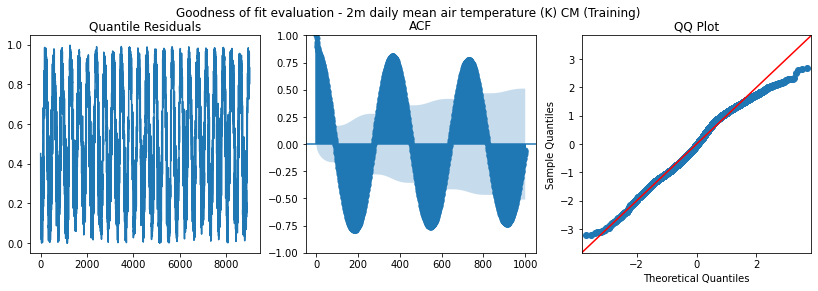

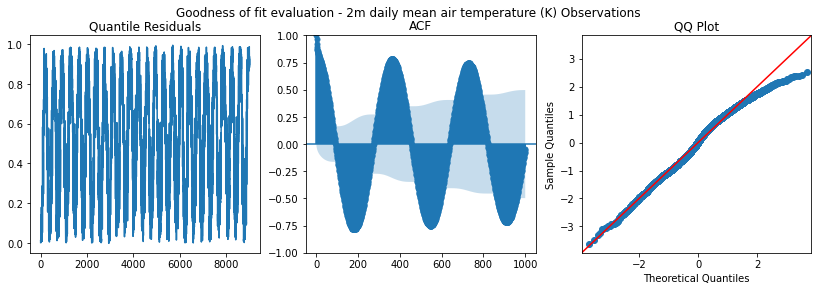

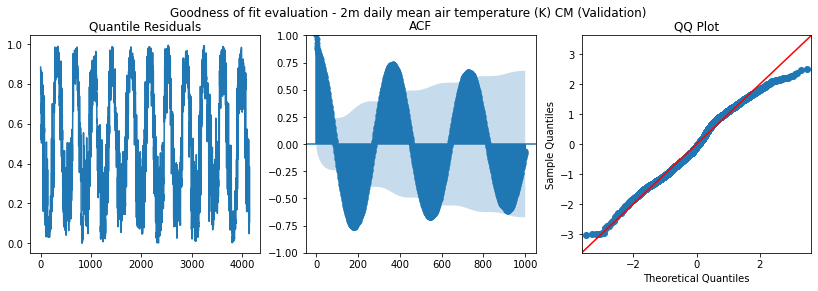

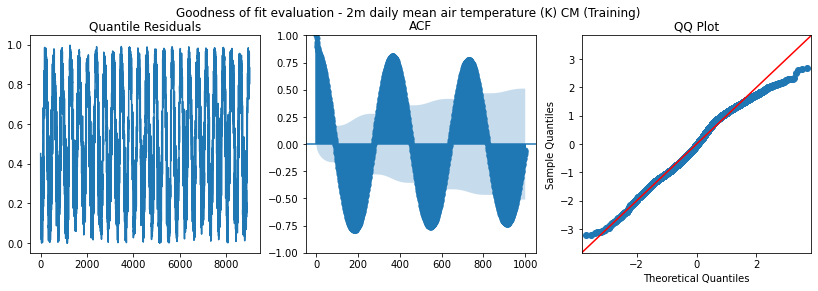

In [8]:
tas_obs_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_obs[:,0,0], 
                                                        variable = 'tas', data_type = 'Observations')
tas_obs_plot_gof

tas_cm_future_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_cm_future[:,0,0], 
                                                        variable = 'tas', data_type = 'CM (Validation)')
tas_cm_future_plot_gof

tas_cm_hist_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_cm_hist[:,0,0], 
                                                        variable = 'tas', data_type = 'CM (Training)')
tas_cm_hist_plot_gof

## Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

def stationarity_adf(dataset):

    adf = np.array([])

    for i in range(dataset.shape[1]):
        for j in range(dataset.shape[2]):
            adf = np.append(adf, adfuller(tas_obs[:, i,j])[1])
            
    return(max(adf))

test = stationarity_adf(tas_cm_hist)
test

1.700113108062837e-07

# Apply de-biasers

In [10]:
# from scipy.stats import norm, laplace - not sure I need this
from PACKAGE_NAME.debias import QuantileDeltaMapping, ISIMIP, QuantileMapping
from scipy.stats import norm, laplace
from PACKAGE_NAME.variables import Temperature, Precipitation

In [11]:
QDM_tas_debiaser = QuantileDeltaMapping(distribution=norm, time_window_length=50)
QM_tas_debiaser = QuantileMapping.from_variable(variable=Temperature, delta_type="additive")

QDM_pr_debiaser = QuantileDeltaMapping.from_variable(variable=Precipitation)
QM_pr_debiaser = QuantileMapping.for_precipitation(delta_type = "multiplicative", precipitation_model_type = "censored", precipitation_censoring_value = 0.1)

In [12]:
tas_debiased_QDM = QDM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)
tas_debiased_QM = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)

test_debiased_hist = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_hist)

pr_debiased_QDM = QDM_pr_debiaser.apply(pr_obs, pr_cm_hist, pr_cm_future)
pr_debiased_QM = QM_pr_debiaser.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/debias/_quantile_delta_mapping.py:128: RuntimeWarning: invalid value encountered in true_divide
  cm_future_time_window
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 44.81it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 388.84it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 400.53it/s]


----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:330: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


# Evaluation of bias corrected results on validation period

## Marginal Aspects

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/3476657550.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_marginal_boxplot.show()
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/3476657550.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_hist.show()
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/3476657550.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_bias_map.show()


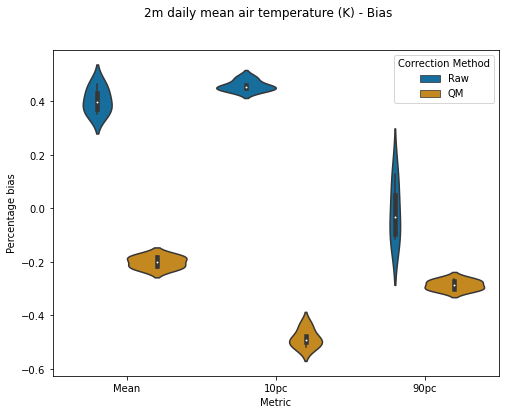

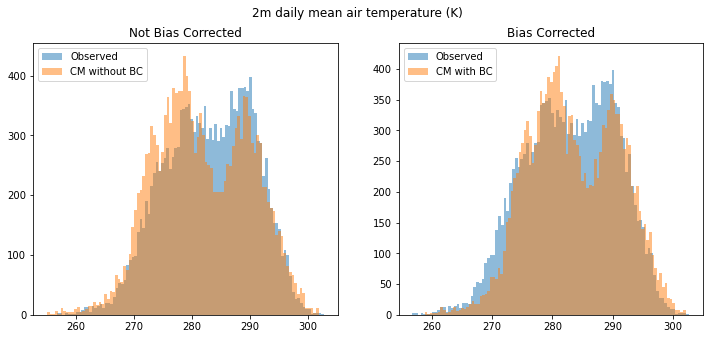

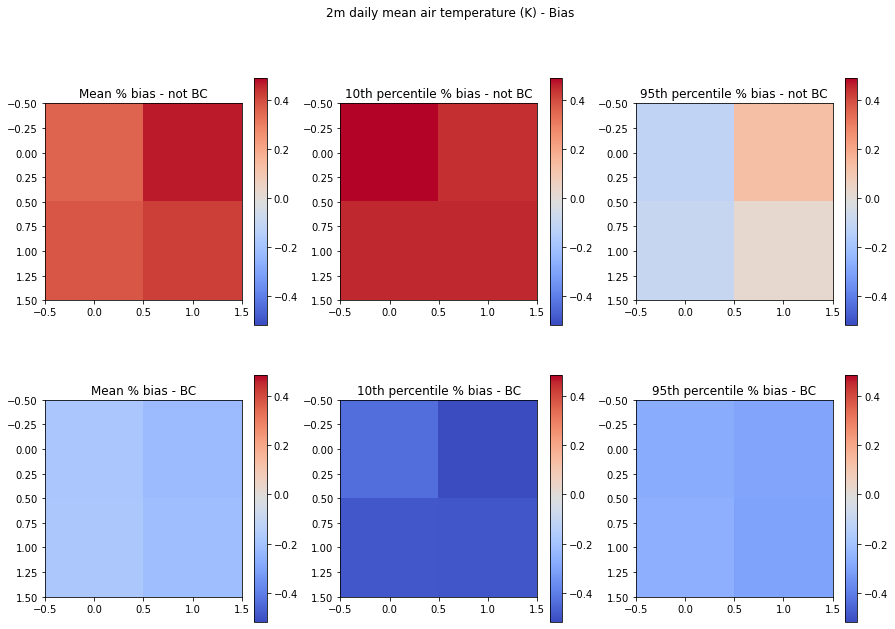

In [13]:
# overview boxplot
figure_marginal_boxplot = evaluation_functions.marginal_bias_violinplot('tas', tas_obs_validate, tas_cm_future, tas_debiased_QM, 'QM')
figure_marginal_boxplot.show()

# histogram over entire area
figure_hist = evaluation_functions.histogram_plot('tas', np.ndarray.flatten(tas_obs_validate), np.ndarray.flatten(tas_cm_future), 
                    np.ndarray.flatten(tas_debiased_QM))
figure_hist.show()

# spatial distribution of bias
figure_bias_map = evaluation_functions.marginal_bias_plot('tas', tas_obs_validate, tas_cm_future, tas_debiased_QM)
figure_bias_map.show()

## Climate change indices - extreme / exceedance over threshold analysis

### Marginal

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/1718922467.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_EOT_probability_plot.show()


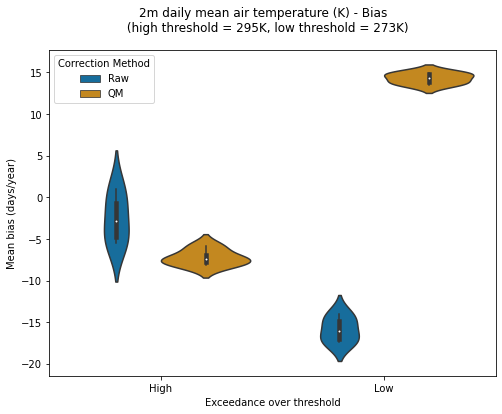

In [14]:
tas_EOT_probability = evaluation_functions.EOT_probability(variable = 'tas', name_BC = 'QM', 
                                                                    data_obs = tas_obs_validate, 
                                                                    data_raw = tas_cm_future, 
                                                                    data_bc = tas_debiased_QM)
    
tas_EOT_probability_plot = evaluation_functions.EOT_mean_bias_days_violinplot('tas', tas_EOT_probability)
tas_EOT_probability_plot.show()

### Temporal

High 2m daily mean air temperature (K) spell-length - Observations compared to Raw CM 
 KS-test 
 Maximum distance between cdf functions: 0.1125 
 p-value = 0.5599166924771006
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

Low 2m daily mean air temperature (K) spell-length - Observations compared to Raw CM 
 KS-test 
 Maximum distance between cdf functions: 0.11037037037037037 
 p-value = 0.11110219596517001
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

High 2m daily mean air temperature (K) spell-length - Observations compared to debiased CM (QM) 
 KS-test 
 Maximum distance between cdf functions: 0.17738549618320612 
 p-value = 0.07550505988611944
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

Low 2m daily mean air temperature (K) spell-length - Observations compared to deabised CM (QM) 
 KS-test 

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/699617462.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_spell_length_plot.show()


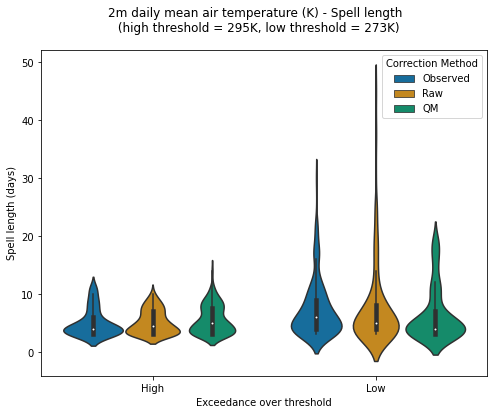

In [15]:
tas_spell_length_plot = evaluation_functions.EOT_spell_length_violinplot(variable = 'tas', data_obs = tas_obs_validate, data_raw = tas_cm_future,
                                data_bc = tas_debiased_QM, name_BC = 'QM', minimum_spell_length = 2)
tas_spell_length_plot.show()

### Spatial

Compute percent of gridcell above / below threshold, if one cell is above/below threshold - this should give a distribution that signifies co-occurence

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/61573160.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_spatial_clusters_plot.show()


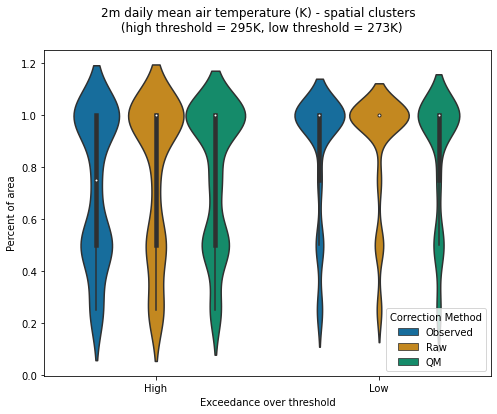

In [16]:
# spatial clusters
tas_spatial_clusters = evaluation_functions.EOT_spatial_compounding(variable = 'tas', name_BC = 'QM', 
                                                                    data_obs = tas_obs_validate, 
                                                                    data_raw = tas_cm_future, 
                                                                    data_bc = tas_debiased_QM)
    
tas_spatial_clusters_plot = evaluation_functions.clusters_violinplot('tas', tas_spatial_clusters, clustertype = 'spatial', columnname = 'Percent of area')
tas_spatial_clusters_plot.show()

### Spatio-temporal clustering

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/1839663873.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_spatiotemporal_clusters_plot.show()


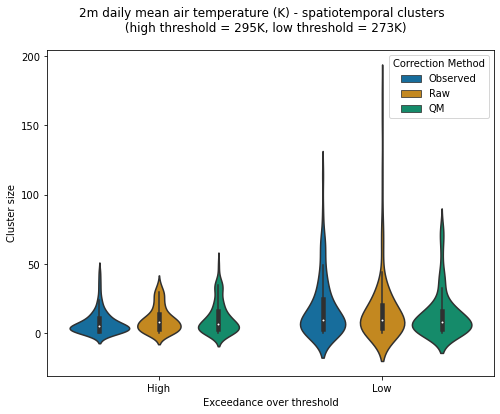

In [17]:
# spatiotemporally connected clusters
tas_spatiotemporal_clusters = evaluation_functions.calculate_spatiotemporal_clusters(variable = 'tas', name_BC = 'QM', 
                                         data_obs = tas_obs_validate, 
                                         data_raw = tas_cm_future, 
                                         data_bc = tas_debiased_QM)
tas_spatiotemporal_clusters

tas_spatiotemporal_clusters_plot = evaluation_functions.clusters_violinplot('tas', tas_spatiotemporal_clusters, 
                                                                            'spatiotemporal',
                                                                           columnname='Cluster size')
tas_spatiotemporal_clusters_plot.show()

## Trend preservation

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_12778/188511315.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_add_trend.show()


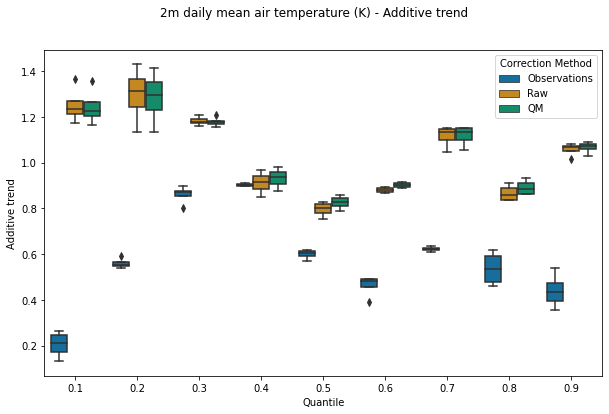

In [18]:
tas_add_trend = evaluation_functions.calculate_full_trend_matrix(variable = 'tas', data_obs_hist = tas_obs, data_obs_future = tas_obs_validate,
                                   data_raw_hist = tas_cm_hist, data_raw_future = tas_cm_future, 
                                   data_bc_hist = test_debiased_hist, data_bc_future = tas_debiased_QM,
                                  trendtype = 'Additive trend', trendtype_number=0)
tas_add_trend.show()


## Spatial and multivariate correlation

### Spatial

In [19]:
# Moran's I - is taking ages at the moment...
test2 = evaluation_functions.calculate_moransi_spatial(tas_obs)
test2

array([-1.14562442e-04, -1.80345953e-03, -6.42259209e-03, ...,
       -3.60627718e-03, -1.92185833e-03, -8.39088361e-06])

In [20]:
tas_rmse = evaluation_functions.rmse_spatial_correlation(variable = 'tas', name_BC = 'QM', 
                                                         data_obs = tas_obs_validate, 
                                                         data_raw = tas_cm_future, 
                                                         data_bc = tas_debiased_QM)

tas_rmse_boxplot = rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmse)
tas_rmse_boxplot.show()

NameError: name 'mean_squared_error' is not defined

### Multivariate

# Conclusion